### For Station SIO

Found 172 Rrs bands.
First 10 bands: [('Rrs_346.0', 346.0), ('Rrs_348.0', 348.0), ('Rrs_351.0', 351.0), ('Rrs_353.0', 353.0), ('Rrs_356.0', 356.0), ('Rrs_358.0', 358.0), ('Rrs_361.0', 361.0), ('Rrs_363.0', 363.0), ('Rrs_366.0', 366.0), ('Rrs_368.0', 368.0)]
Targets: ['abundance_delicatissima_cells_L', 'abundance_seriata_cells_L']
Saved: ndi_corr_abundance_delicatissima_cells_L.csv


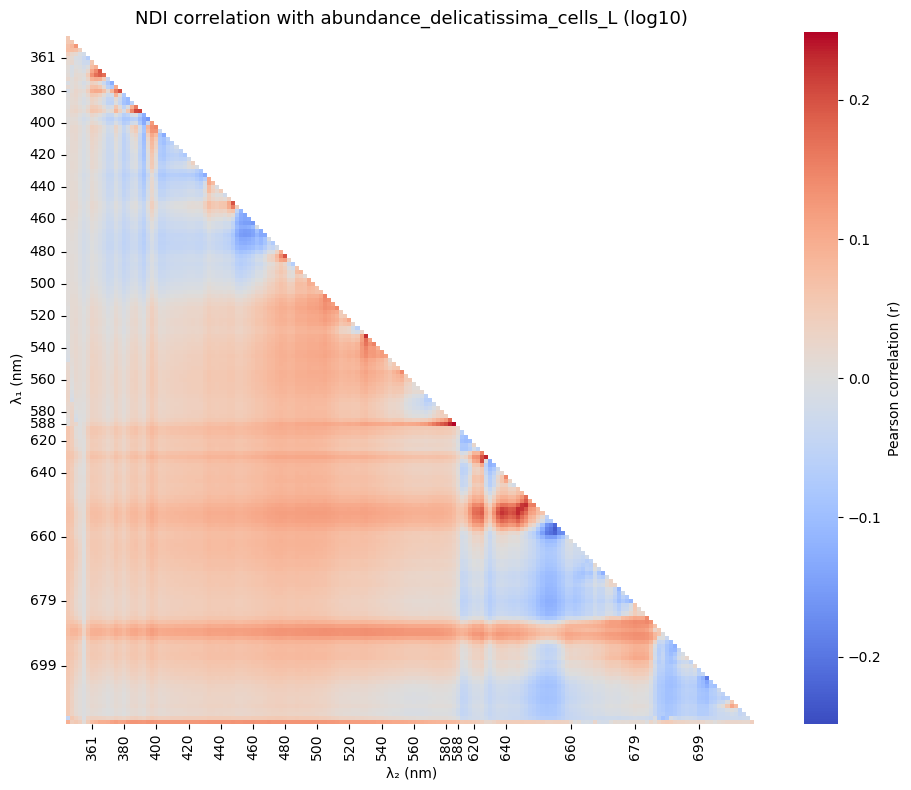

Saved: ndi_corr_abundance_seriata_cells_L.csv


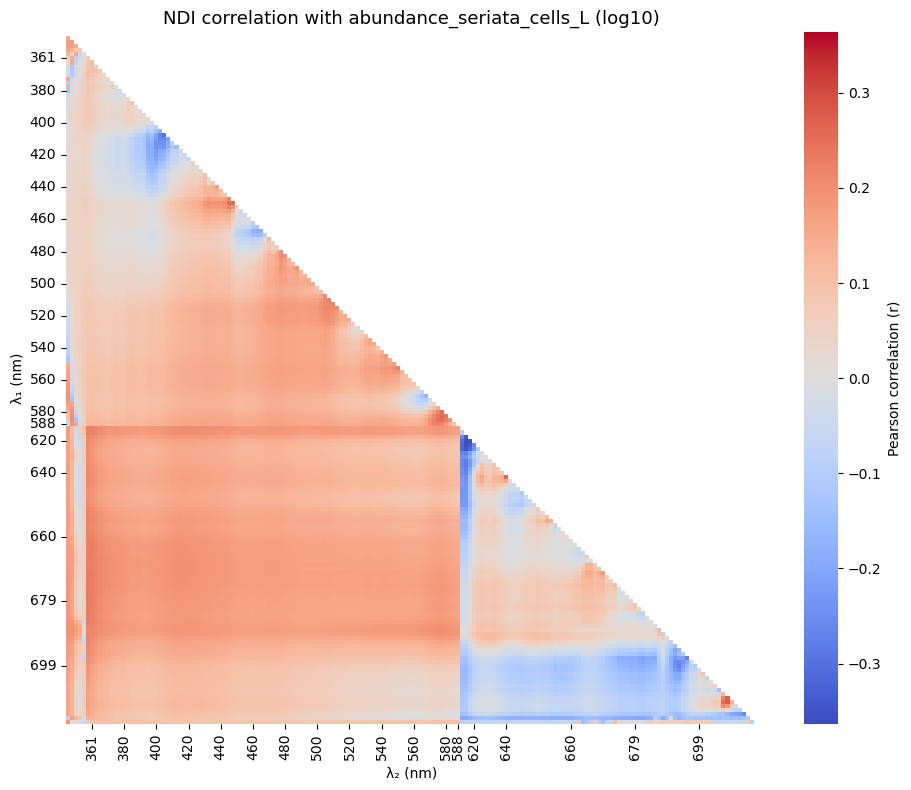


Top 20 |r| band pairs for abundance_delicatissima_cells_L
  λ1=588, λ2=586  r=+0.2485
  λ1=586, λ2=588  r=-0.2485
  λ1=588, λ2=583  r=+0.2340
  λ1=583, λ2=588  r=-0.2340
  λ1=627, λ2=630  r=-0.2331
  λ1=630, λ2=627  r=+0.2331
  λ1=652, λ2=643  r=+0.2314
  λ1=643, λ2=652  r=-0.2314
  λ1=651, λ2=643  r=+0.2305
  λ1=643, λ2=651  r=-0.2305
  λ1=646, λ2=650  r=-0.2298
  λ1=650, λ2=646  r=+0.2298
  λ1=657, λ2=655  r=-0.2292
  λ1=655, λ2=657  r=+0.2292
  λ1=532, λ2=530  r=+0.2262
  λ1=530, λ2=532  r=-0.2262
  λ1=651, λ2=645  r=+0.2242
  λ1=645, λ2=651  r=-0.2242
  λ1=652, λ2=637  r=+0.2239
  λ1=637, λ2=652  r=-0.2239

Top 20 |r| band pairs for abundance_seriata_cells_L
  λ1=615, λ2=620  r=+0.3636
  λ1=620, λ2=615  r=-0.3636
  λ1=615, λ2=623  r=+0.3586
  λ1=623, λ2=615  r=-0.3586
  λ1=618, λ2=620  r=+0.3537
  λ1=620, λ2=618  r=-0.3537
  λ1=625, λ2=615  r=-0.3468
  λ1=615, λ2=625  r=+0.3468
  λ1=618, λ2=623  r=+0.3409
  λ1=623, λ2=618  r=-0.3409
  λ1=618, λ2=615  r=-0.3398
  λ1=615, λ2=618  r=

C:\Users\DELL\AppData\Local\Temp\ipykernel_16280\3107402669.py:233: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked = ndi_corr.stack(dropna=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_16280\3107402669.py:233: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked = ndi_corr.stack(dropna=True)


In [6]:
# ============================================================
# NDI (Normalized Difference Index) correlation heatmap
# Target(s): Pn_delicatissima, Pn_seriata  (abundance; cells/L)
# NDI: (Rrs(λ1) - Rrs(λ2)) / (Rrs(λ1) + Rrs(λ2))
# ============================================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1) USER SETTINGS
# ----------------------------
CSV_PATH = r"D:/Academic/Training/PACE Hackweek/cal_habs_filled_rrs.csv"   # <-- change this
DATE_COL = "date"

# Your abundance columns in the CSV (as shown in your screenshot)
ABUND_COLS = ["Pn_delicat", "Pn_seriata"]  # keep as-is if that's your exact header text

# Output options
SAVE_NDI_CORR_CSV = True
OUT_PREFIX = "ndi_corr"  # output file prefix

# Plot options
FIGSIZE = (10, 8)
TICK_EVERY = 1           # set to 1 to show all wavelengths; use e.g. 2, 4, 5, 10 if too crowded
CMAP = "coolwarm"


# ----------------------------
# 2) HELPERS
# ----------------------------
def find_rrs_columns(df: pd.DataFrame):
    """
    Returns (rrs_cols, wavelengths) where wavelengths are numeric (float) parsed from 'Rrs_XXX' columns.
    """
    rrs_cols = [c for c in df.columns if str(c).startswith("Rrs_")]

    if not rrs_cols:
        raise ValueError("No columns starting with 'Rrs_' were found. Check your CSV header names.")

    wl_map = {}
    for c in rrs_cols:
        # Accept patterns like: Rrs_346.0, Rrs_346, Rrs_346_0 (rare), etc.
        m = re.search(r"Rrs[_\-]([0-9]+(?:\.[0-9]+)?)", str(c))
        if not m:
            raise ValueError(f"Could not parse wavelength from column: {c}")
        wl = float(m.group(1))
        wl_map[c] = wl

    # Sort by wavelength
    rrs_cols_sorted = sorted(rrs_cols, key=lambda c: wl_map[c])
    wavelengths_sorted = [wl_map[c] for c in rrs_cols_sorted]
    return rrs_cols_sorted, wavelengths_sorted


def compute_ndi_corr(df: pd.DataFrame, rrs_cols, wavelengths, target_col: str):
    """
    Computes a wavelength x wavelength correlation matrix between NDI(λ1,λ2) and log10(target).
    Returns ndi_corr (DataFrame indexed/columned by wavelengths).
    """
    # Target: log10, clipped to avoid -inf
    target = pd.to_numeric(df[target_col], errors="coerce").clip(lower=1e-4)
    target = np.log10(target)

    # Reflectances
    rrs = df[rrs_cols].apply(pd.to_numeric, errors="coerce")

    # Correlation matrix container
    ndi_corr = pd.DataFrame(index=wavelengths, columns=wavelengths, dtype=float)

    # Compute correlation for each band-pair
    for i, wl1 in enumerate(wavelengths):
        a = rrs.iloc[:, i]
        for j, wl2 in enumerate(wavelengths):
            if i == j:
                continue
            b = rrs.iloc[:, j]

            denom = (a + b)
            ndi = (a - b) / denom
            # Avoid division by zero / tiny denom -> inf
            ndi = ndi.where(np.isfinite(ndi), np.nan)

            # Pairwise valid rows (both NDI and target finite)
            valid = ndi.notna() & np.isfinite(target)
            if valid.sum() < 3:
                ndi_corr.at[wl1, wl2] = np.nan
            else:
                ndi_corr.at[wl1, wl2] = ndi[valid].corr(target[valid])

    return ndi_corr

def _make_ticks_from_wavelengths(wavelengths, step_nm=20):
    """
    Choose tick locations approximately every `step_nm` nm using nearest available band.
    Returns (tick_positions, tick_labels).
    """
    wls = np.array(wavelengths, dtype=float)
    start = np.ceil(wls.min() / step_nm) * step_nm
    stop  = np.floor(wls.max() / step_nm) * step_nm
    desired = np.arange(start, stop + 0.1, step_nm)

    idx = []
    for v in desired:
        idx.append(int(np.argmin(np.abs(wls - v))))
    idx = sorted(set(idx))

    ticks = [i + 0.5 for i in idx]               # heatmap cell centers
    labels = [f"{wls[i]:.0f}" for i in idx]      # integer nm labels
    return ticks, labels


def plot_heatmap(ndi_corr: pd.DataFrame, title: str, tick_step_nm=20):
    """
    Cleaner, standard NDI correlation heatmap:
    - Lower triangle only
    - Ticks labeled every ~tick_step_nm nm
    - Square aspect
    - Symmetric diverging color limits around 0
    """
    arr = ndi_corr.values.astype(float)

    # mask: diagonal + upper triangle + NaNs
    mask = np.triu(np.ones_like(arr, dtype=bool), k=0) | ~np.isfinite(arr)

    # symmetric color scaling
    vmax = np.nanmax(np.abs(arr))
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 0.1
    vmax = max(0.1, float(vmax))

    fig, ax = plt.subplots(figsize=FIGSIZE)

    sns.heatmap(
        ndi_corr,
        mask=mask,
        cmap=CMAP,
        center=0,
        vmin=-vmax,
        vmax=vmax,
        square=True,
        linewidths=0,
        cbar_kws={"label": "Pearson correlation (r)"},
        ax=ax
    )

    # Clean wavelength ticks
    wls = ndi_corr.columns.to_list()
    xticks, xlabels = _make_ticks_from_wavelengths(wls, step_nm=tick_step_nm)
    yticks, ylabels = _make_ticks_from_wavelengths(wls, step_nm=tick_step_nm)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, rotation=0)

    ax.set_xlabel("λ₂ (nm)")
    ax.set_ylabel("λ₁ (nm)")
    ax.set_title(title, fontsize=13)

    plt.tight_layout()
    plt.show()



# ----------------------------
# 3) LOAD + CLEAN
# ----------------------------
df = pd.read_csv(CSV_PATH)

# If your date column exists, parse it (optional but helpful)
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# Rename abundance columns (what you asked):
# - Pn_delicatissima  -> abundance_delicatissima_cells_L
# - Pn_seriata        -> abundance_seriata_cells_L
rename_map = {
    "Pn_delicatissima": "abundance_delicatissima_cells_L",
    "Pn_delicat": "abundance_delicatissima_cells_L",   # supports your screenshot header
    "Pn_seriata": "abundance_seriata_cells_L",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Verify abundance columns are present
targets = []
if "abundance_delicatissima_cells_L" in df.columns:
    targets.append("abundance_delicatissima_cells_L")
if "abundance_seriata_cells_L" in df.columns:
    targets.append("abundance_seriata_cells_L")

if not targets:
    raise ValueError(
        "Could not find abundance columns. I looked for 'Pn_delicatissima'/'Pn_delicat' and 'Pn_seriata'. "
        "Check your CSV headers and update rename_map/ABUND_COLS accordingly."
    )

# Identify Rrs columns and wavelengths
rrs_cols, wavelengths = find_rrs_columns(df)

print(f"Found {len(rrs_cols)} Rrs bands.")
print("First 10 bands:", list(zip(rrs_cols[:10], wavelengths[:10])))
print("Targets:", targets)

# ----------------------------
# 4) RUN FOR EACH TARGET
# ----------------------------
for tcol in targets:
    ndi_corr = compute_ndi_corr(df, rrs_cols, wavelengths, target_col=tcol)

    # Save matrix (optional)
    if SAVE_NDI_CORR_CSV:
        out_csv = f"{OUT_PREFIX}_{tcol}.csv"
        ndi_corr.to_csv(out_csv, index=True)
        print(f"Saved: {out_csv}")

    # Plot heatmap
    plot_heatmap(ndi_corr, title=f"NDI correlation with {tcol} (log10)", tick_step_nm=20)


# ----------------------------
# 5) OPTIONAL: Find best band pairs
# ----------------------------
for tcol in targets:
    ndi_corr = pd.read_csv(f"{OUT_PREFIX}_{tcol}.csv", index_col=0)
    ndi_corr.columns = ndi_corr.columns.astype(float)
    ndi_corr.index = ndi_corr.index.astype(float)

    # stack and rank by absolute correlation, excluding diagonal/NaN
    stacked = ndi_corr.stack(dropna=True)
    stacked = stacked[stacked.index.get_level_values(0) != stacked.index.get_level_values(1)]
    top = stacked.reindex(stacked.abs().sort_values(ascending=False).index).head(20)

    print("\nTop 20 |r| band pairs for", tcol)
    for (wl1, wl2), r in top.items():
        print(f"  λ1={wl1:g}, λ2={wl2:g}  r={r:+.4f}")


Using columns: Pn_delicatissima and Pn_seriata
Found 172 Rrs bands (346–719 nm).
Abundance summary:
 count        97.000000
mean      42288.237113
std       80796.790798
min           0.000000
25%        3130.000000
50%        9387.000000
75%       36923.000000
max      488010.000000
Name: abundance_cells_L, dtype: float64
Saved: ndi_corr_abundance_cells_L.csv


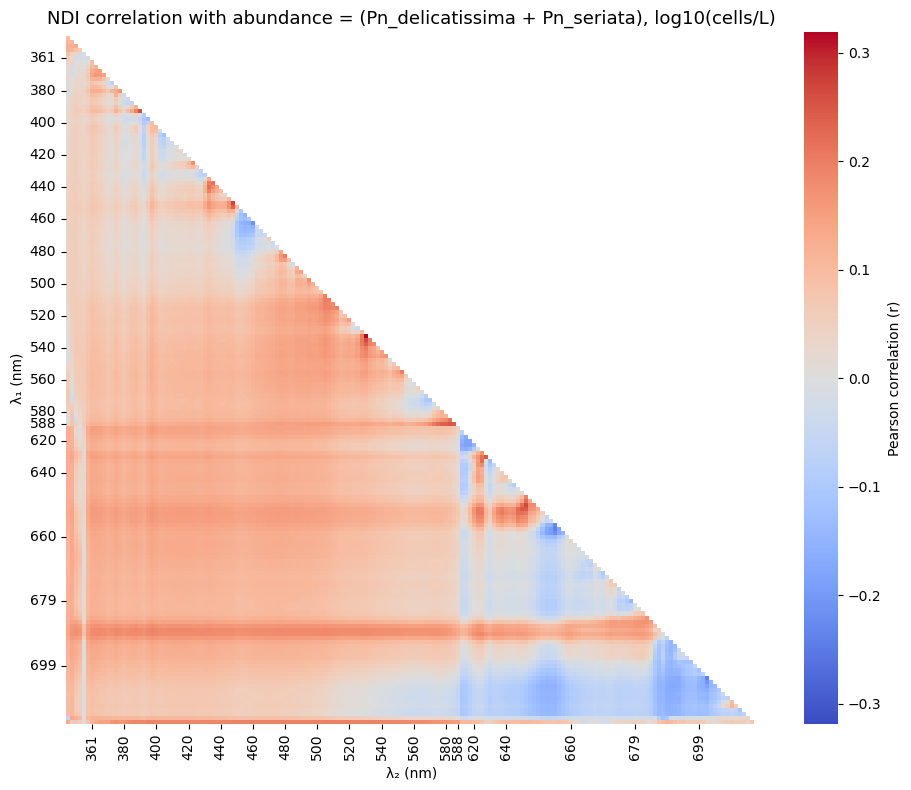


Top 20 |r| NDI band pairs:
  λ1=530 nm, λ2=532 nm  r=-0.3187
  λ1=532 nm, λ2=530 nm  r=+0.3187
  λ1=447 nm, λ2=450 nm  r=-0.2710
  λ1=450 nm, λ2=447 nm  r=+0.2710
  λ1=646 nm, λ2=650 nm  r=-0.2664
  λ1=650 nm, λ2=646 nm  r=+0.2664
  λ1=530 nm, λ2=535 nm  r=-0.2659
  λ1=535 nm, λ2=530 nm  r=+0.2659
  λ1=390 nm, λ2=393 nm  r=-0.2580
  λ1=393 nm, λ2=390 nm  r=+0.2580
  λ1=583 nm, λ2=588 nm  r=-0.2504
  λ1=588 nm, λ2=583 nm  r=+0.2504
  λ1=588 nm, λ2=586 nm  r=+0.2486
  λ1=586 nm, λ2=588 nm  r=-0.2486
  λ1=651 nm, λ2=645 nm  r=+0.2479
  λ1=645 nm, λ2=651 nm  r=-0.2479
  λ1=646 nm, λ2=651 nm  r=-0.2473
  λ1=651 nm, λ2=646 nm  r=+0.2473
  λ1=630 nm, λ2=627 nm  r=+0.2453
  λ1=627 nm, λ2=630 nm  r=-0.2453


C:\Users\DELL\AppData\Local\Temp\ipykernel_16280\4255525073.py:196: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked = ndi_corr.stack(dropna=True)


In [5]:
# ============================================================
# NDI correlation heatmap with combined abundance
# abundance_cells_L = Pn_delicatissima + Pn_seriata  (cells/L)
# NDI(λ1,λ2) = (Rrs(λ1) - Rrs(λ2)) / (Rrs(λ1) + Rrs(λ2))
# Target = log10(abundance_cells_L)
# ============================================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1) SETTINGS
# ----------------------------
CSV_PATH = r"D:/Academic/Training/PACE Hackweek/cal_habs_filled_rrs.csv"
DATE_COL = "date"

# candidate names (your file has Pn_delicatissima)
PN_DEL_CANDIDATES = ["Pn_delicatissima", "Pn_delicat"]
PN_SER_COL = "Pn_seriata"

# Plot style
FIGSIZE = (10, 8)
CMAP = "coolwarm"
TICK_STEP_NM = 20          # label every ~20 nm (clean)
SAVE_NDI_CORR_CSV = True
OUT_CSV = "ndi_corr_abundance_cells_L.csv"

# numeric safety
MIN_ABUND = 1e-4
MIN_DENOM = 1e-12

# ----------------------------
# 2) HELPERS
# ----------------------------
def find_rrs_columns(df: pd.DataFrame):
    rrs_cols = [c for c in df.columns if str(c).startswith("Rrs_")]
    if not rrs_cols:
        raise ValueError("No 'Rrs_*' columns found.")

    wl_map = {}
    for c in rrs_cols:
        m = re.search(r"Rrs[_\-]([0-9]+(?:\.[0-9]+)?)", str(c))
        if not m:
            raise ValueError(f"Could not parse wavelength from: {c}")
        wl_map[c] = float(m.group(1))

    rrs_cols_sorted = sorted(rrs_cols, key=lambda c: wl_map[c])
    wavelengths_sorted = [wl_map[c] for c in rrs_cols_sorted]
    return rrs_cols_sorted, wavelengths_sorted


def pick_column(df: pd.DataFrame, candidates):
    """Return the first candidate column that exists, else None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None


def make_ticks_from_wavelengths(wavelengths, step_nm=20):
    wls = np.array(wavelengths, dtype=float)
    start = np.ceil(wls.min() / step_nm) * step_nm
    stop = np.floor(wls.max() / step_nm) * step_nm
    desired = np.arange(start, stop + 0.1, step_nm)

    idx = []
    for v in desired:
        idx.append(int(np.argmin(np.abs(wls - v))))
    idx = sorted(set(idx))

    ticks = [i + 0.5 for i in idx]
    labels = [f"{wls[i]:.0f}" for i in idx]
    return ticks, labels


def compute_ndi_corr(rrs: pd.DataFrame, wavelengths, target: pd.Series):
    n = len(wavelengths)
    out = np.full((n, n), np.nan, dtype=float)

    R = rrs.to_numpy(dtype=float)
    t = target.to_numpy(dtype=float)
    t_ok = np.isfinite(t)

    for i in range(n):
        a = R[:, i]
        for j in range(n):
            if i == j:
                continue
            b = R[:, j]
            denom = a + b

            denom_ok = np.isfinite(denom) & (np.abs(denom) > MIN_DENOM)
            ndi = (a - b) / denom

            ok = np.isfinite(ndi) & denom_ok & t_ok
            if ok.sum() < 4:
                continue

            out[i, j] = pd.Series(ndi[ok]).corr(pd.Series(t[ok]))

    return pd.DataFrame(out, index=wavelengths, columns=wavelengths)


def plot_heatmap(ndi_corr: pd.DataFrame, title: str):
    arr = ndi_corr.values.astype(float)
    mask = np.triu(np.ones_like(arr, dtype=bool), k=0) | ~np.isfinite(arr)

    vmax = np.nanmax(np.abs(arr))
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 0.1
    vmax = max(0.1, float(vmax))

    fig, ax = plt.subplots(figsize=FIGSIZE)

    sns.heatmap(
        ndi_corr,
        mask=mask,
        cmap=CMAP,
        center=0,
        vmin=-vmax,
        vmax=vmax,
        square=True,
        linewidths=0.0,
        cbar_kws={"label": "Pearson correlation (r)"},
        ax=ax
    )

    xticks, xlabels = make_ticks_from_wavelengths(ndi_corr.columns.to_list(), step_nm=TICK_STEP_NM)
    yticks, ylabels = make_ticks_from_wavelengths(ndi_corr.index.to_list(), step_nm=TICK_STEP_NM)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, rotation=0)

    ax.set_xlabel("λ₂ (nm)")
    ax.set_ylabel("λ₁ (nm)")
    ax.set_title(title, fontsize=13)

    plt.tight_layout()
    plt.show()


# ----------------------------
# 3) LOAD
# ----------------------------
df = pd.read_csv(CSV_PATH)

if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

pn_del_col = pick_column(df, PN_DEL_CANDIDATES)
if pn_del_col is None:
    raise ValueError(f"Missing Pn_del column. Tried: {PN_DEL_CANDIDATES}")

if PN_SER_COL not in df.columns:
    raise ValueError(f"Missing Pn_seriata column: {PN_SER_COL}")

print("Using columns:", pn_del_col, "and", PN_SER_COL)

# combined abundance (cells/L)
pn_del = pd.to_numeric(df[pn_del_col], errors="coerce").fillna(0)
pn_ser = pd.to_numeric(df[PN_SER_COL], errors="coerce").fillna(0)
df["abundance_cells_L"] = pn_del + pn_ser

# target: log10(abundance)
target = np.log10(df["abundance_cells_L"].clip(lower=MIN_ABUND))

# Rrs bands
rrs_cols, wavelengths = find_rrs_columns(df)
rrs = df[rrs_cols].apply(pd.to_numeric, errors="coerce")

print(f"Found {len(rrs_cols)} Rrs bands ({min(wavelengths):.0f}–{max(wavelengths):.0f} nm).")
print("Abundance summary:\n", df["abundance_cells_L"].describe())

# ----------------------------
# 4) COMPUTE + PLOT
# ----------------------------
ndi_corr = compute_ndi_corr(rrs, wavelengths, target)

if SAVE_NDI_CORR_CSV:
    ndi_corr.to_csv(OUT_CSV)
    print("Saved:", OUT_CSV)

plot_heatmap(
    ndi_corr,
    title="NDI correlation with abundance = (Pn_delicatissima + Pn_seriata), log10(cells/L)"
)

# ----------------------------
# 5) TOP BAND PAIRS
# ----------------------------
stacked = ndi_corr.stack(dropna=True)
stacked = stacked[stacked.index.get_level_values(0) != stacked.index.get_level_values(1)]
top = stacked.reindex(stacked.abs().sort_values(ascending=False).index).head(20)

print("\nTop 20 |r| NDI band pairs:")
for (wl1, wl2), r in top.items():
    print(f"  λ1={wl1:.0f} nm, λ2={wl2:.0f} nm  r={r:+.4f}")


### All Stations Combined

"D:\Academic\Training\PACE Hackweek\cal_habs_filled_chl_sst_rrs_all_stations.csv"

In [ ]:
# ============================================================
# NDI (Normalized Difference Index) correlation heatmap
# Target(s): Pn_delicatissima, Pn_seriata  (abundance; cells/L)
# NDI: (Rrs(λ1) - Rrs(λ2)) / (Rrs(λ1) + Rrs(λ2))
# ============================================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1) USER SETTINGS
# ----------------------------
CSV_PATH = r"D:\Academic\Training\PACE Hackweek\cal_habs_filled_chl_sst_rrs_all_stations.csv"   # <-- change this
DATE_COL = "date"

# Your abundance columns in the CSV (as shown in your screenshot)
ABUND_COLS = ["Pn_delicat", "Pn_seriata"]  # keep as-is if that's your exact header text

# Output options
SAVE_NDI_CORR_CSV = True
OUT_PREFIX = "ndi_corr"  # output file prefix

# Plot options
FIGSIZE = (10, 8)
TICK_EVERY = 1           # set to 1 to show all wavelengths; use e.g. 2, 4, 5, 10 if too crowded
CMAP = "coolwarm"


# ----------------------------
# 2) HELPERS
# ----------------------------
def find_rrs_columns(df: pd.DataFrame):
    """
    Returns (rrs_cols, wavelengths) where wavelengths are numeric (float) parsed from 'Rrs_XXX' columns.
    """
    rrs_cols = [c for c in df.columns if str(c).startswith("Rrs_")]

    if not rrs_cols:
        raise ValueError("No columns starting with 'Rrs_' were found. Check your CSV header names.")

    wl_map = {}
    for c in rrs_cols:
        # Accept patterns like: Rrs_346.0, Rrs_346, Rrs_346_0 (rare), etc.
        m = re.search(r"Rrs[_\-]([0-9]+(?:\.[0-9]+)?)", str(c))
        if not m:
            raise ValueError(f"Could not parse wavelength from column: {c}")
        wl = float(m.group(1))
        wl_map[c] = wl

    # Sort by wavelength
    rrs_cols_sorted = sorted(rrs_cols, key=lambda c: wl_map[c])
    wavelengths_sorted = [wl_map[c] for c in rrs_cols_sorted]
    return rrs_cols_sorted, wavelengths_sorted


def compute_ndi_corr(df: pd.DataFrame, rrs_cols, wavelengths, target_col: str):
    """
    Computes a wavelength x wavelength correlation matrix between NDI(λ1,λ2) and log10(target).
    Returns ndi_corr (DataFrame indexed/columned by wavelengths).
    """
    # Target: log10, clipped to avoid -inf
    target = pd.to_numeric(df[target_col], errors="coerce").clip(lower=1e-4)
    target = np.log10(target)

    # Reflectances
    rrs = df[rrs_cols].apply(pd.to_numeric, errors="coerce")

    # Correlation matrix container
    ndi_corr = pd.DataFrame(index=wavelengths, columns=wavelengths, dtype=float)

    # Compute correlation for each band-pair
    for i, wl1 in enumerate(wavelengths):
        a = rrs.iloc[:, i]
        for j, wl2 in enumerate(wavelengths):
            if i == j:
                continue
            b = rrs.iloc[:, j]

            denom = (a + b)
            ndi = (a - b) / denom
            # Avoid division by zero / tiny denom -> inf
            ndi = ndi.where(np.isfinite(ndi), np.nan)

            # Pairwise valid rows (both NDI and target finite)
            valid = ndi.notna() & np.isfinite(target)
            if valid.sum() < 3:
                ndi_corr.at[wl1, wl2] = np.nan
            else:
                ndi_corr.at[wl1, wl2] = ndi[valid].corr(target[valid])

    return ndi_corr

def _make_ticks_from_wavelengths(wavelengths, step_nm=20):
    """
    Choose tick locations approximately every `step_nm` nm using nearest available band.
    Returns (tick_positions, tick_labels).
    """
    wls = np.array(wavelengths, dtype=float)
    start = np.ceil(wls.min() / step_nm) * step_nm
    stop  = np.floor(wls.max() / step_nm) * step_nm
    desired = np.arange(start, stop + 0.1, step_nm)

    idx = []
    for v in desired:
        idx.append(int(np.argmin(np.abs(wls - v))))
    idx = sorted(set(idx))

    ticks = [i + 0.5 for i in idx]               # heatmap cell centers
    labels = [f"{wls[i]:.0f}" for i in idx]      # integer nm labels
    return ticks, labels


def plot_heatmap(ndi_corr: pd.DataFrame, title: str, tick_step_nm=20):
    """
    Cleaner, standard NDI correlation heatmap:
    - Lower triangle only
    - Ticks labeled every ~tick_step_nm nm
    - Square aspect
    - Symmetric diverging color limits around 0
    """
    arr = ndi_corr.values.astype(float)

    # mask: diagonal + upper triangle + NaNs
    mask = np.triu(np.ones_like(arr, dtype=bool), k=0) | ~np.isfinite(arr)

    # symmetric color scaling
    vmax = np.nanmax(np.abs(arr))
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 0.1
    vmax = max(0.1, float(vmax))

    fig, ax = plt.subplots(figsize=FIGSIZE)

    sns.heatmap(
        ndi_corr,
        mask=mask,
        cmap=CMAP,
        center=0,
        vmin=-vmax,
        vmax=vmax,
        square=True,
        linewidths=0,
        cbar_kws={"label": "Pearson correlation (r)"},
        ax=ax
    )

    # Clean wavelength ticks
    wls = ndi_corr.columns.to_list()
    xticks, xlabels = _make_ticks_from_wavelengths(wls, step_nm=tick_step_nm)
    yticks, ylabels = _make_ticks_from_wavelengths(wls, step_nm=tick_step_nm)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, rotation=0)

    ax.set_xlabel("λ₂ (nm)")
    ax.set_ylabel("λ₁ (nm)")
    ax.set_title(title, fontsize=13)

    plt.tight_layout()
    plt.show()



# ----------------------------
# 3) LOAD + CLEAN
# ----------------------------
df = pd.read_csv(CSV_PATH)

# If your date column exists, parse it (optional but helpful)
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# Rename abundance columns (what you asked):
# - Pn_delicatissima  -> abundance_delicatissima_cells_L
# - Pn_seriata        -> abundance_seriata_cells_L
rename_map = {
    "Pn_delicatissima": "abundance_delicatissima_cells_L",
    "Pn_delicat": "abundance_delicatissima_cells_L",   # supports your screenshot header
    "Pn_seriata": "abundance_seriata_cells_L",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Verify abundance columns are present
targets = []
if "abundance_delicatissima_cells_L" in df.columns:
    targets.append("abundance_delicatissima_cells_L")
if "abundance_seriata_cells_L" in df.columns:
    targets.append("abundance_seriata_cells_L")

if not targets:
    raise ValueError(
        "Could not find abundance columns. I looked for 'Pn_delicatissima'/'Pn_delicat' and 'Pn_seriata'. "
        "Check your CSV headers and update rename_map/ABUND_COLS accordingly."
    )

# Identify Rrs columns and wavelengths
rrs_cols, wavelengths = find_rrs_columns(df)

print(f"Found {len(rrs_cols)} Rrs bands.")
print("First 10 bands:", list(zip(rrs_cols[:10], wavelengths[:10])))
print("Targets:", targets)

# ----------------------------
# 4) RUN FOR EACH TARGET
# ----------------------------
for tcol in targets:
    ndi_corr = compute_ndi_corr(df, rrs_cols, wavelengths, target_col=tcol)

    # Save matrix (optional)
    if SAVE_NDI_CORR_CSV:
        out_csv = f"{OUT_PREFIX}_{tcol}.csv"
        ndi_corr.to_csv(out_csv, index=True)
        print(f"Saved: {out_csv}")

    # Plot heatmap
    plot_heatmap(ndi_corr, title=f"NDI correlation with {tcol} (log10)", tick_step_nm=20)


# ----------------------------
# 5) OPTIONAL: Find best band pairs
# ----------------------------
for tcol in targets:
    ndi_corr = pd.read_csv(f"{OUT_PREFIX}_{tcol}.csv", index_col=0)
    ndi_corr.columns = ndi_corr.columns.astype(float)
    ndi_corr.index = ndi_corr.index.astype(float)

    # stack and rank by absolute correlation, excluding diagonal/NaN
    stacked = ndi_corr.stack(dropna=True)
    stacked = stacked[stacked.index.get_level_values(0) != stacked.index.get_level_values(1)]
    top = stacked.reindex(stacked.abs().sort_values(ascending=False).index).head(20)

    print("\nTop 20 |r| band pairs for", tcol)
    for (wl1, wl2), r in top.items():
        print(f"  λ1={wl1:g}, λ2={wl2:g}  r={r:+.4f}")


Found 172 Rrs bands.
First 10 bands: [('Rrs_346.0', 346.0), ('Rrs_348.0', 348.0), ('Rrs_351.0', 351.0), ('Rrs_353.0', 353.0), ('Rrs_356.0', 356.0), ('Rrs_358.0', 358.0), ('Rrs_361.0', 361.0), ('Rrs_363.0', 363.0), ('Rrs_366.0', 366.0), ('Rrs_368.0', 368.0)]
Targets: ['abundance_delicatissima_cells_L', 'abundance_seriata_cells_L']
